This notebook trains a random forest to predict the $Q_2$ of the 1 degree gridded data. It is similar to [this analysis  of the .25 degree data](https://github.com/VulcanTechnologies/fv3net/blob/90b0897fe1811a1e6928965eb1e1ae0b33273a0f/notebooks/2019-08-14-demonstrate-sklearn-wrapper.ipynb).

In [1]:
from src.models.base import SklearnWrapper
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from src.data import open_dataset
from src.metrics import r2_score
from src.data.calc import mass_integrate
import xarray as xr

np.random.seed(1)

In [2]:
pwd

'/home/noahb/workspace/fv3net/notebooks'

## Preprocessing

Open the data and split it into a training and testing portion. Also, open the data for lon = 0 to make comparision plots with.

In [3]:
ds = open_dataset("1degTrain")

ds = ds.assign(q2=ds.advection_qv + ds.storage_qv)
# remove poles and bad time points
ds = ds.sel(lat=slice(-80, 80)).dropna('time')

# flatten and shuffle the data
flat = ds.stack(sample=['time', 'lat', 'lon']).load()
n = len(flat.sample)
ind = np.random.choice(n, n)
shuffled = flat.isel(sample=ind)

## Split into training and testing portions

In [4]:
n_train = 5000
n_test = 10000

train = shuffled.isel(sample=slice(0, n_train))
test = shuffled.isel(sample=slice(n_train, n_train + n_test))

## Train a scikit-learn model

In [8]:
# Boiler plate for creating a scikit learn model
sklearn_model = TransformedTargetRegressor(
#     Ridge(alpha=.01, normalize=True),
    RandomForestRegressor(n_estimators=50, n_jobs=4, min_samples_leaf=10),
    StandardScaler(),
)
# some custom wrapper code
model = SklearnWrapper(sklearn_model)


# fit a model, predict and compute a score
model.fit(['qv', 'temp', 'lhflx', 'shflx'], ['q2'], 'sample', train)

SklearnWrapper()

The validation score is very low for some reason.

## Evaluation

In [9]:
y = model.predict(test, 'sample')
r2s = r2_score(test, y, 'sample')

/home/noahb/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/core/dataset.py:2307: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  index = pd.MultiIndex(v.levels, v.labels, v.sortorder,


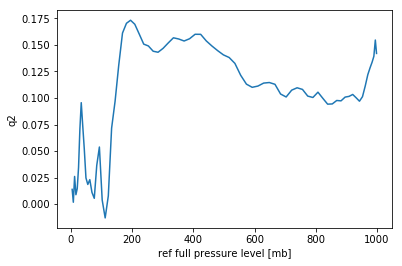

In [10]:
r2s.q2.plot(label='Q2')

## Predictions

In [11]:
equator = ds.sel(lat=0, method='nearest').isel(time=0)
y = model.predict(equator, 'lon')

Text(0.5, 1.0, 'RF')

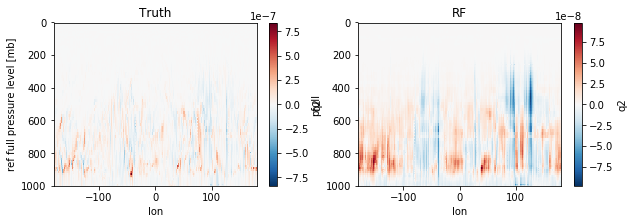

In [12]:

fig, (a, b) = plt.subplots(1, 2, figsize=(10, 3))
equator.q2.plot(x='lon', yincrease=False, ax=a)
y.q2.plot(x='lon', yincrease=False, ax=b)

a.set_title('Truth')
b.set_title('RF')

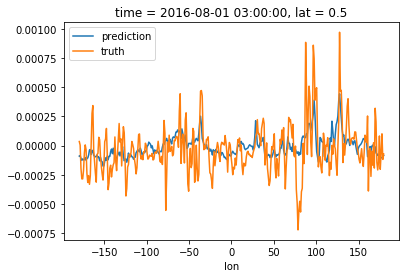

In [13]:
net_precip = -mass_integrate(y.q2, equator.dp)
net_precip.plot(label='prediction')

net_precip = -mass_integrate(equator.q2, equator.dp)
net_precip.plot(label='truth')
plt.legend()

We can see the RF fails to predict the fluctuations of precipitation, but does correlate.

## Interpretability

This plot shows the feature importances.

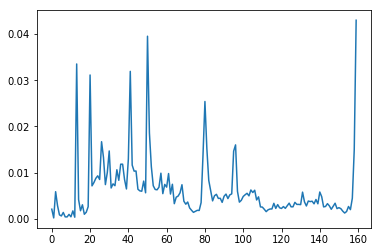

In [15]:
plt.plot(sklearn_model.regressor_.feature_importances_)

These are not smooth at all, which indicates some irregularity.